# MCLP

## Module

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
import json
import os
import networkx as nx
import osmnx as ox
import time, math
import itertools
import logging
import pyproj
import warnings
warnings.filterwarnings('ignore')

from geopandas.tools import sjoin
from shapely.geometry import Point
from folium import Choropleth
from folium import GeoJsonTooltip
from tqdm import tqdm
from pulp import *
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from IPython.display import Image
from shapely.geometry import Polygon, LineString, Point
from fiona.crs import from_string
from pyproj import Transformer

## 데이터

In [ ]:
# 공원 위치 데이터
park = pd.read_csv("data/park.csv", encoding = "utf-8")
park = park[["공원명", "지역", 'X', 'Y']]
park = park.rename(columns = {'X' : "경도", 'Y' : "위도", "지역" : '구'})
park = park[park.구 != "과천시"]
park = park.dropna()
park = park.reset_index()
park = park.drop("index", axis = 1)
park

,공원명,구,경도,위도
0,남산도시자연공원,중구,126.990377,37.550140
1,길동생태공원,강동구,127.154779,37.540394
2,서울숲,성동구,127.041798,37.543072
3,월드컵공원,마포구,126.878907,37.571805
4,광화문시민열린마당,종로구,126.978023,37.575045
...,...,...,...,...
124,숭인근린공원,종로구,127.017827,37.576442
125,서일대뒷산공원,중랑구,127.098782,37.587716
126,용마도시자연공원(사가정공원),중랑구,127.095997,37.579762
127,문화비축기지,마포구,126.893246,37.571718


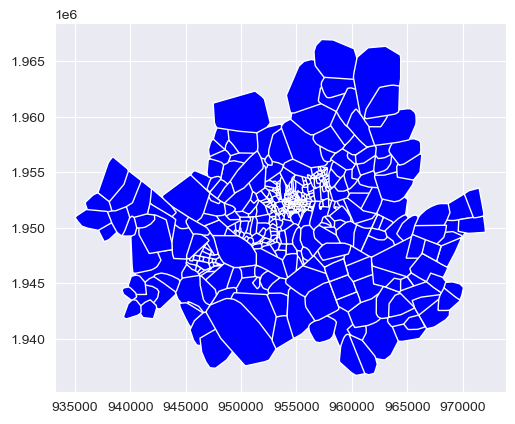

In [ ]:
# 읍면동 공간 데이터
geo = gpd.read_file("data/emd.shp", encoding = "cp949")
geo = geo.astype({"EMD_CD" : "int"})
seoul = geo[geo["EMD_CD"] < 20000000]
ax = seoul.convex_hull.plot(color = "blue", edgecolor = "white")
plt.show()

## 지도

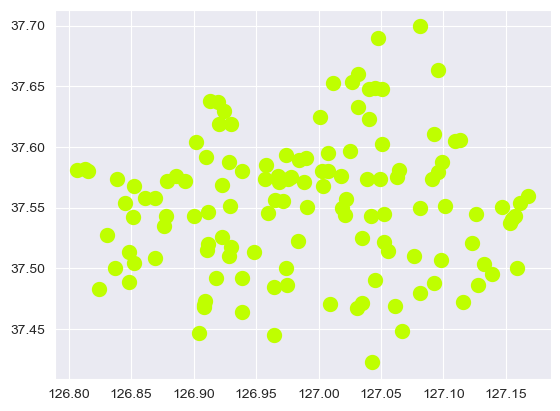

In [ ]:
plt.scatter(park['경도'],park['위도'],
            color= "#bfff00",
            linewidths = 5)

In [ ]:
seoul.crs

In [ ]:
print(seoul.crs)
seoul.set_crs(epsg=5179, inplace= True)
new_seoul = seoul.to_crs(epsg=4326)
new_seoul.to_csv('new_seoul.csv')

None


<function matplotlib.pyplot.show(close=None, block=None)>

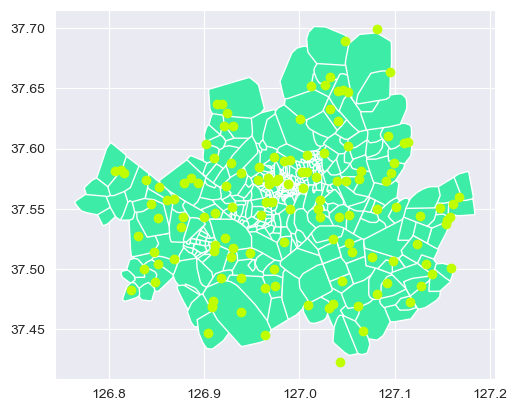

In [ ]:
new_seoul.convex_hull.plot(color='#3ceca7', edgecolor="w")
plt.scatter(park['경도'],park['위도'],
            color= "#bfff00",linewidths = 1)
plt.show

## 커버 범위 계산

In [ ]:
# 포인트 데이터를 Geopandas의 GeoDataFrame으로 변환
geo_yy = [Point(xy) for xy in zip(park['경도'], park['위도'])]
yy_gdf = gpd.GeoDataFrame(park, crs = 'EPSG:4326', geometry = geo_yy)

In [ ]:
# 좌표계 코드
new_seoul.geometry = new_seoul.geometry.to_crs('EPSG:4326')
new_seoul.geometry = new_seoul.geometry.to_crs('EPSG:3857')
yy_gdf.geometry = yy_gdf.geometry.to_crs('EPSG:3857')

In [ ]:
# 각 포인트 버퍼 생성
buf = 2000 # 참고 논문 평균 채집거리
# buf = 492 # 도시 꿀벌 평균 채집거리
yy_gdf['buffer'] = yy_gdf.geometry.buffer(buf)

In [ ]:
# 센트로이드 메소드
# 격자의 중심점 생성
new_seoul['centroid'] = new_seoul.geometry.centroid

In [ ]:
# 격자와의 공간 관계를 확인하여 커버되는 격자 수 계산
covered_grid_yy = []

In [ ]:
for idx, grid in new_seoul.iterrows():
    for _, point in yy_gdf.iterrows():
        # centroid가 버퍼 내부에 있는지 확인
        if grid.centroid.within(point['buffer']):
            covered_grid_yy.append(idx)


# 커버되는 격자 수를 계산합니다.
coverage_count_yy = len(set(covered_grid_yy))

coverage_count_yy

423

In [ ]:
new_seoul.to_csv("new_seoul.csv")

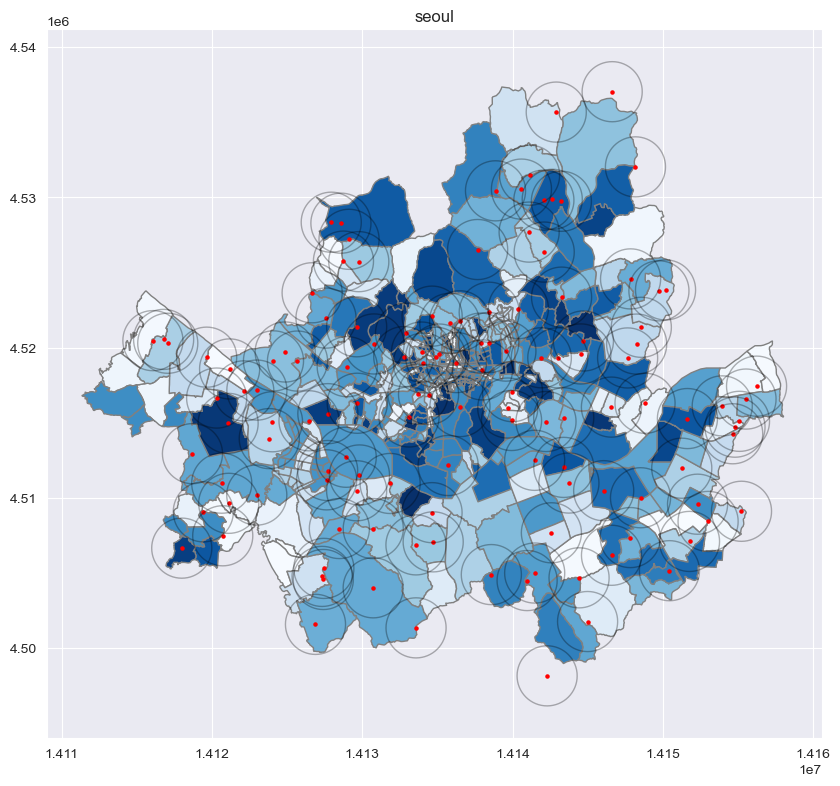

In [ ]:
# 인구 격자 시각화
ax = new_seoul.plot(column = 'EMD_KOR_NM', cmap = 'Blues', figsize = (10, 10), edgecolor = 'gray')
plt.title("seoul")

# 현재 포인트를 시각화
yy_gdf.plot(ax = plt.gca(), color = 'red', label = "park", markersize = 5)

# 버퍼 시각화
yy_gdf['buffer'].plot(ax = plt.gca(), facecolor = 'none', edgecolor = 'black', alpha = 0.3, linewidth = 1)
# new_seoul['centroid'].plot(ax = plt.gca(), color = 'green', label = 'Centroid', markersize = 1)

# plt.legend()
plt.show()

## MCLP without weights

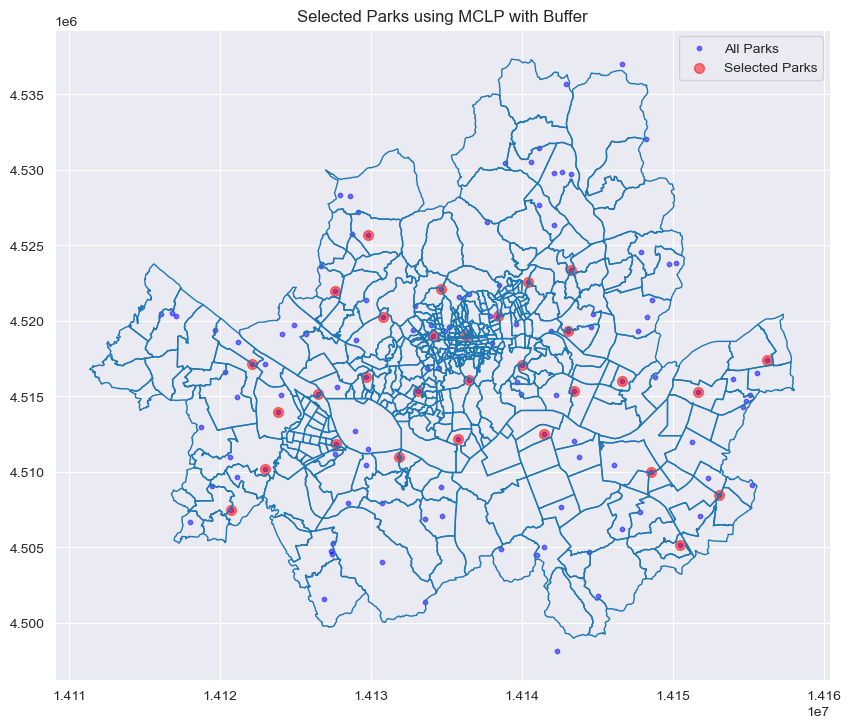

In [ ]:
centroids = new_seoul[['centroid']]
centroids = centroids.dropna()
centroids = centroids.reset_index(drop=True)
centroids_gdf = gpd.GeoDataFrame(centroids, crs='EPSG:4326', geometry='centroid')
def MCLP_with_buffer(centroids, facilities, coverage_buffers, num_facilities):
    covered = np.zeros((len(centroids), len(facilities)), dtype=bool)
    for i, facility in facilities.iterrows():
        buffer_geom = facility['buffer']
        covered[:, i] = centroids.within(buffer_geom)

    selected = []
    for _ in range(num_facilities):
        best_covered = 0
        best_facility = None
        for i, facility in enumerate(facilities.iterrows()):
            if i in selected:
                continue
            new_covered = np.sum(np.max(covered[:, selected + [i]], axis=1))
            if new_covered > best_covered:
                best_covered = new_covered
                best_facility = i
        if best_facility is not None:
            selected.append(best_facility)
    return facilities.iloc[selected]
from scipy.spatial import distance_matrix
selected_points = MCLP_with_buffer(centroids_gdf, yy_gdf, yy_gdf['buffer'], 30)
fig, ax = plt.subplots(figsize=(10, 10))
new_seoul.boundary.plot(ax=ax, linewidth=1)
yy_gdf.plot(ax=ax, color='blue', alpha=0.5, markersize=10, label='All Parks')
selected_points.plot(ax=ax, color='red', alpha=0.5, markersize=50, label='Selected Parks')
plt.legend()
plt.title('Selected Parks using MCLP with Buffer')
plt.show()

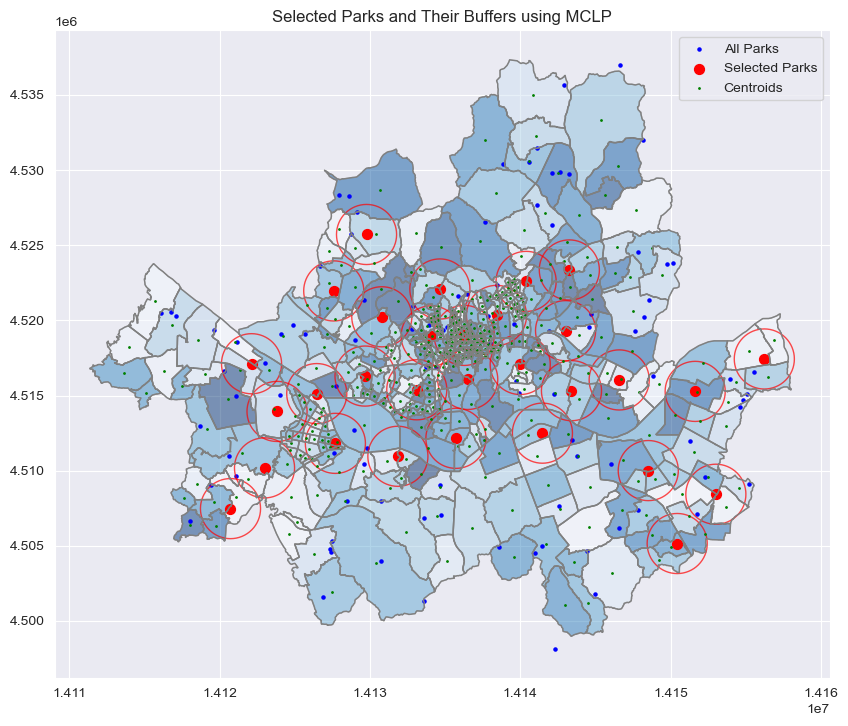

In [ ]:
# MCLP with buffer
# Plotting the selected points and their buffers
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Seoul regions
new_seoul.boundary.plot(ax=ax, linewidth=1, edgecolor='gray')
new_seoul.plot(column='EMD_KOR_NM', ax=ax, cmap='Blues', edgecolor='gray', alpha=0.5)

# Plot all park points
yy_gdf.plot(ax=ax, color='blue', markersize=5, label='All Parks')

# Plot buffers of selected parks
selected_points['buffer'].plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.7, linewidth=1, label='Selected Park Buffer')

# Plot selected park points
selected_points.plot(ax=ax, color='red', markersize=50, label='Selected Parks')

# Plot centroids
new_seoul['centroid'].plot(ax=ax, color='green', markersize=1, label='Centroids')

# Legend and title
plt.legend()
plt.title("Selected Parks and Their Buffers using MCLP")
plt.show()

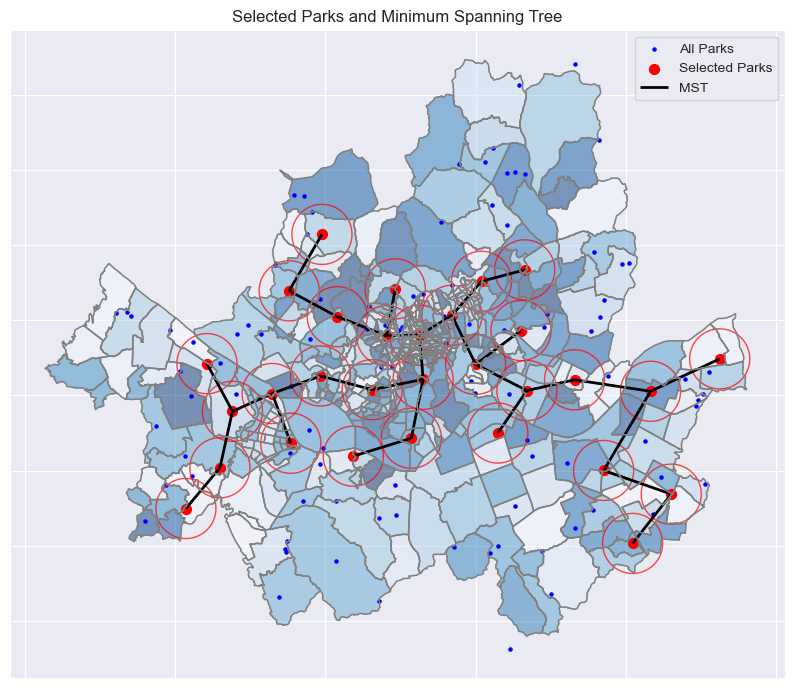

In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes
for idx, row in selected_points.iterrows():
    G.add_node(idx, pos=(row.geometry.x, row.geometry.y))

# Add edges with distances as weights
for i, row1 in selected_points.iterrows():
    for j, row2 in selected_points.iterrows():
        if i != j:
            distance = row1.geometry.distance(row2.geometry)
            G.add_edge(i, j, weight=distance)

# Get positions for the nodes in the graph
pos = nx.get_node_attributes(G, 'pos')

# Find the Minimum Spanning Tree (MST) to ensure all nodes are connected with minimum distance
mst = nx.minimum_spanning_tree(G, weight='weight')

# Plotting the selected points, their buffers, and the MST
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Seoul regions
new_seoul.boundary.plot(ax=ax, linewidth=1, edgecolor='gray')
new_seoul.plot(column='EMD_KOR_NM', ax=ax, cmap='Blues', edgecolor='gray', alpha=0.5)

# Plot all park points
yy_gdf.plot(ax=ax, color='blue', markersize=5, label='All Parks')

# Plot buffers of selected parks
selected_points['buffer'].plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.7, linewidth=1, label='Selected Park Buffer')

# Plot selected park points
selected_points.plot(ax=ax, color='red', markersize=50, label='Selected Parks')

# Plot centroids
# new_seoul['centroid'].plot(ax=ax, color='green', markersize=1, label='Centroids')

# Plot the Minimum Spanning Tree
mst_edges = list(mst.edges())
nx.draw_networkx_edges(G, pos, edgelist=mst_edges, ax=ax, edge_color='black', width=2, label='MST')

# Legend and title
plt.legend()
plt.title("Selected Parks and Minimum Spanning Tree")
plt.show()

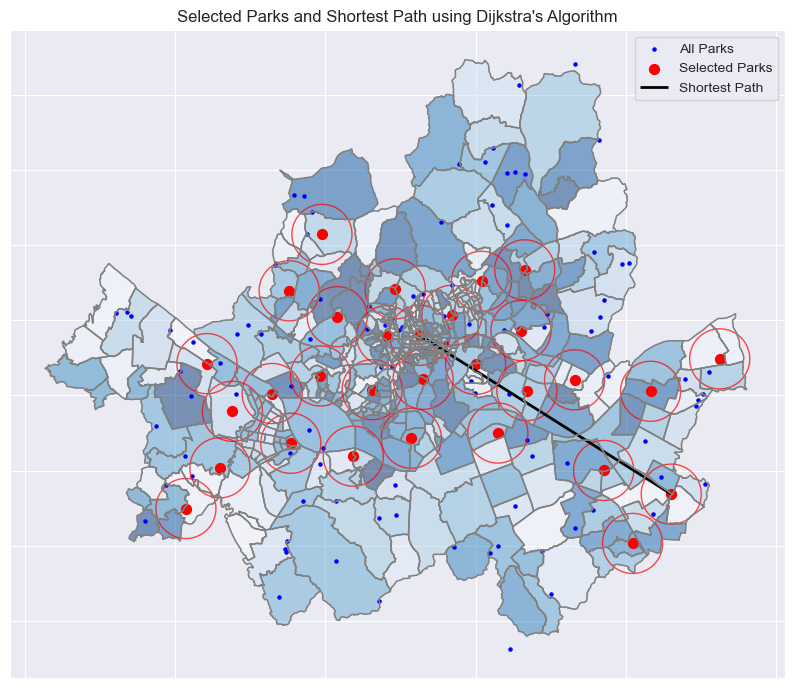

In [ ]:
G = nx.Graph()

# Add nodes
for idx, row in selected_points.iterrows():
    G.add_node(idx, pos=(row.geometry.x, row.geometry.y))

# Add edges with distances as weights
for i, row1 in selected_points.iterrows():
    for j, row2 in selected_points.iterrows():
        if i != j:
            distance = row1.geometry.distance(row2.geometry)
            G.add_edge(i, j, weight=distance)

# Get positions for the nodes in the graph
pos = nx.get_node_attributes(G, 'pos')

# Use Dijkstra's algorithm to find the shortest path from the first node to the last node
start_node = list(G.nodes)[0]
end_node = list(G.nodes)[-1]
path = nx.dijkstra_path(G, source=start_node, target=end_node, weight='weight')

# Plotting the selected points, their buffers, and the shortest path
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Seoul regions
new_seoul.boundary.plot(ax=ax, linewidth=1, edgecolor='gray')
new_seoul.plot(column='EMD_KOR_NM', ax=ax, cmap='Blues', edgecolor='gray', alpha=0.5)

# Plot all park points
yy_gdf.plot(ax=ax, color='blue', markersize=5, label='All Parks')

# Plot buffers of selected parks
selected_points['buffer'].plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.7, linewidth=1, label='Selected Park Buffer')

# Plot selected park points
selected_points.plot(ax=ax, color='red', markersize=50, label='Selected Parks')

# Plot centroids
# new_seoul['centroid'].plot(ax=ax, color='green', markersize=1, label='Centroids')

# Plot the shortest path using Dijkstra's algorithm
path_edges = list(zip(path, path[1:]))
nx.draw_networkx_edges(G, pos, edgelist=path_edges, ax=ax, edge_color='black', width=2, label='Shortest Path')

# Legend and title
plt.legend()
plt.title("Selected Parks and Shortest Path using Dijkstra's Algorithm")
plt.show()

## K-mean 클러스터링

In [ ]:
park_gdf = yy_gdf["geometry"]
park_gdf

0      POINT (14136504.137 4516069.187)
1      POINT (14154805.261 4514700.747)
2      POINT (14142228.285 4515076.749)
3      POINT (14124095.320 4519111.572)
4      POINT (14135128.829 4519566.627)
                     ...               
124    POINT (14139559.790 4519762.847)
125    POINT (14148571.659 4521346.446)
126    POINT (14148261.668 4520229.223)
127    POINT (14125691.474 4519099.421)
128    POINT (14150443.196 4505149.873)
Name: geometry, Length: 129, dtype: geometry

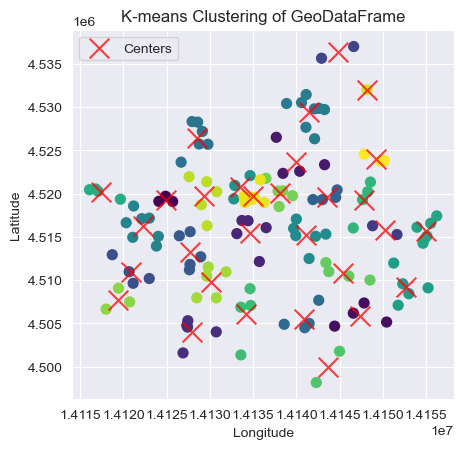

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Extract coordinates for clustering
coords = np.array([[point.x, point.y] for point in yy_gdf.geometry])

# Define number of clusters
num_clusters = 30

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=10).fit(coords)
yy_gdf['cluster'] = kmeans.labels_

# Plotting the results
fig, ax = plt.subplots()
yy_gdf.plot(ax=ax, column='cluster', categorical=True, legend=True, cmap='viridis', markersize=50)

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x', label='Centers')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of GeoDataFrame')
plt.legend()
plt.show()

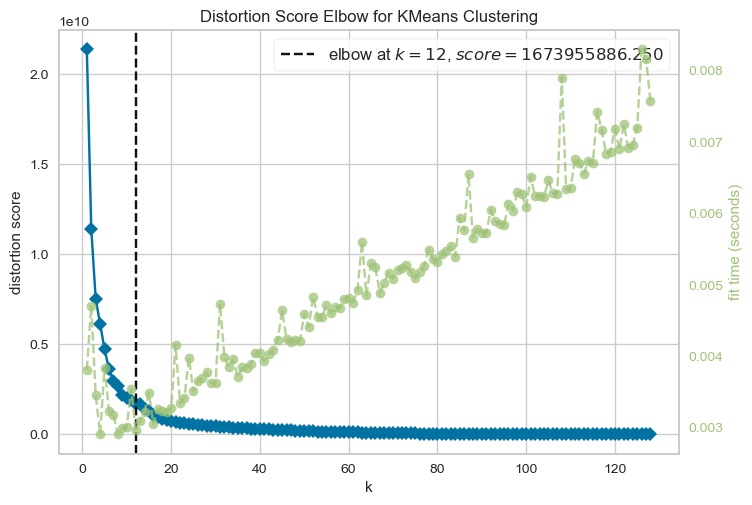

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# 거점 수 찾기
# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(n_clusters=num_clusters, random_state=10)
visualizer = KElbowVisualizer(kmeans, k=(1,129))
visualizer.fit(coords)
visualizer.show()

## 엔트로피 가중치

### 변수 로드

In [ ]:
total = pd.read_csv("data/df_0601.csv", encoding = "utf-8")

In [ ]:
# 사용할 열들
total = total[['구','val', '주민등록인구수','평균기온(°C)', '일강수량(mm)', '평균 풍속(m/s)','방제여부','골프장','경지정리가 된 논','경지정리가 안 된 논','기타 초지','경지정리가 된 밭', '경기정리가 안된 밭','공업시설','문화,체육,휴양시설', '교육,행정시설', '기타 공공시설']]
# 열 이름 바꾸기
total = total.rename(columns = {"val" : "건폐율"})
# 결측치 처리(평균)
total["평균기온(°C)"] = total["평균기온(°C)"].fillna(total["평균기온(°C)"].mean())
total["일강수량(mm)"] = total["일강수량(mm)"].fillna(total["일강수량(mm)"].mean())
total["평균 풍속(m/s)"] = total["평균 풍속(m/s)"].fillna(total["평균 풍속(m/s)"].mean())
# 결측치 처리(0)
total["골프장"] = total["골프장"].fillna(0)
total["경지정리가 된 논"] = total["경지정리가 된 논"].fillna(0)
total["경지정리가 안 된 논"] = total["경지정리가 안 된 논"].fillna(0)

In [ ]:
total["구"] = total["구"] + "구"
total["구"] = total["구"].replace('중구구', '중구')
total

,구,건폐율,주민등록인구수,평균기온(°C),일강수량(mm),평균 풍속(m/s),방제여부,골프장,경지정리가 된 논,경지정리가 안 된 논,기타 초지,경지정리가 된 밭,경기정리가 안된 밭,공업시설,"문화,체육,휴양시설","교육,행정시설",기타 공공시설
0,광진구,55.25,351180.0,24.0,0.0,1.3,0,0.0,0.0,0.0,1.48365,0.0,0.03403,0.00673,0.22624,0.3247,0.19803
1,광진구,55.25,351180.0,24.4,0.0,1.4,0,0.0,0.0,0.0,1.48365,0.0,0.03403,0.00673,0.22624,0.3247,0.19803
2,광진구,55.25,351180.0,18.2,5.5,2.0,0,0.0,0.0,0.0,1.48365,0.0,0.03403,0.00673,0.22624,0.3247,0.19803
3,광진구,55.25,351180.0,19.1,0.0,1.9,0,0.0,0.0,0.0,1.48365,0.0,0.03403,0.00673,0.22624,0.3247,0.19803
4,광진구,55.25,351180.0,20.7,0.0,1.6,0,0.0,0.0,0.0,1.48365,0.0,0.03403,0.00673,0.22624,0.3247,0.19803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41872,강동구,52.76,463318.0,19.9,0.0,1.5,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41873,강동구,52.76,463318.0,22.1,0.0,1.5,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41874,강동구,52.76,463318.0,21.4,0.0,1.4,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41875,강동구,52.76,463318.0,21.5,0.0,1.7,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
vegetarian = gpd.read_file("data/2020seoulcityecology_data/현장조사.shp")
vegetarian.to_csv("vegetarian.csv")

In [ ]:
vegetarian = vegetarian[["자치구", "현존식생", "면적"]]
vegetarian = pd.DataFrame(vegetarian)
vegetarian = vegetarian[vegetarian["현존식생"].str.contains('B') | vegetarian["현존식생"].str.contains('D')]
vegetarian = vegetarian[vegetarian["현존식생"].str.startswith(('B', 'D'))]
# 열 이름 바꾸기
vegetarian = vegetarian.rename(columns = {"자치구" : "구"})
vegetarian

,구,현존식생,면적
1,용산구,B3,6519.994508
2,용산구,B3,2881.500006
3,용산구,B3,5812.500811
4,용산구,B3,13594.283161
5,용산구,B3,1156.282154
...,...,...,...
39839,도봉구,D2,1227.872936
39851,노원구,D5,1081.084054
39855,강북구,D2,989.781789
39856,노원구,D2,5616.967321


In [ ]:
def remove_prefix_and_numbers(value):
    if value[0].isalpha():
        return value[0]
    return value

# Apply the function to the DataFrame
vegetarian["현존식생"] = vegetarian["현존식생"].apply(remove_prefix_and_numbers)
# groupby(구)
vegetarian = vegetarian.groupby(["구", "현존식생"]).sum().reset_index()
vegetarianB = vegetarian[vegetarian["현존식생"] == "B"]
vegetarianB = vegetarianB.drop("현존식생", axis = 1)
vegetarianD = vegetarian[vegetarian["현존식생"] == "D"]
vegetarianD = vegetarianD.drop("현존식생", axis = 1)

In [ ]:
vegetarianB

,구,면적
0,강남구,1.977011e+06
2,강동구,1.404563e+06
4,강북구,5.364998e+05
6,강서구,2.770984e+06
8,관악구,9.081410e+05
10,광진구,8.955445e+05
12,구로구,8.418095e+05
14,금천구,3.090002e+05
16,노원구,1.803990e+06
18,도봉구,5.316488e+05


In [ ]:
vegetarianD

,구,면적
1,강남구,8.979017e+05
3,강동구,1.361563e+06
5,강북구,9.570613e+04
7,강서구,3.711327e+06
9,관악구,1.997499e+05
11,광진구,4.433452e+04
13,구로구,5.413706e+05
15,금천구,2.118846e+04
17,노원구,4.830360e+05
19,도봉구,3.771495e+05


### 데이터프레임 합치기

In [ ]:
total = total.groupby("구").mean()
total

,건폐율,주민등록인구수,평균기온(°C),일강수량(mm),평균 풍속(m/s),방제여부,골프장,경지정리가 된 논,경지정리가 안 된 논,기타 초지,경지정리가 된 밭,경기정리가 안된 밭,공업시설,"문화,체육,휴양시설","교육,행정시설",기타 공공시설
구,,,,,,,,,,,,,,,,
강남구,52.33,550282.0,14.157554,3.933824,1.227504,0.064978,0.000000,0.000000,0.000000,5.323423,0.000120,0.519497,0.008035,0.393638,0.368232,0.211031
강동구,52.76,463318.0,13.663882,3.899275,1.415298,0.000000,0.000000,0.000000,0.013032,3.223130,0.000000,0.564518,0.006612,0.209221,0.280179,0.253577
강북구,55.66,292977.0,13.666918,4.203065,1.577725,0.000000,0.000000,0.000000,0.000000,1.070862,0.000000,0.056586,0.002824,0.144573,0.193624,0.236296
강서구,52.55,568826.0,13.664665,3.435890,1.561668,0.020274,0.151243,1.749010,0.046306,6.725931,0.246329,0.393569,0.067987,0.328081,0.347818,0.258875
관악구,56.36,497883.0,12.214318,4.108086,1.910787,0.000000,0.000000,0.000000,0.000000,1.328190,0.000000,0.121618,0.001967,0.258810,0.607687,0.243419
광진구,55.25,351180.0,13.951919,3.753336,1.452561,0.000000,0.000000,0.000000,0.000000,1.494328,0.000000,0.026988,0.005734,0.246443,0.328414,0.201719
구로구,55.78,415651.0,13.872158,3.763172,2.006813,0.000000,0.000000,0.000000,0.000264,2.226338,0.000000,0.365449,0.193487,0.193175,0.276921,0.225006
금천구,52.97,241105.0,14.304236,3.866552,1.791791,0.001095,0.000000,0.000000,0.000000,0.926223,0.000000,0.012237,0.329284,0.091517,0.151005,0.123280
노원구,53.45,502925.0,12.415875,3.842842,1.134509,0.000000,0.227980,0.000000,0.004414,4.057893,0.000000,0.182525,0.014238,0.518479,0.611558,0.381725


In [ ]:
vegetarianB = vegetarianB.rename(columns = {"면적" : "조경수목 식재지"})
vegetarianB = vegetarianB.set_index("구")
vegetarianB

,조경수목 식재지
구,
강남구,1.977011e+06
강동구,1.404563e+06
강북구,5.364998e+05
강서구,2.770984e+06
관악구,9.081410e+05
광진구,8.955445e+05
구로구,8.418095e+05
금천구,3.090002e+05
노원구,1.803990e+06


In [ ]:
vegetarianD = vegetarianD.rename(columns = {"면적" : "경작지"})
vegetarianD = vegetarianD.set_index("구")
vegetarianD

,경작지
구,
강남구,8.979017e+05
강동구,1.361563e+06
강북구,9.570613e+04
강서구,3.711327e+06
관악구,1.997499e+05
광진구,4.433452e+04
구로구,5.413706e+05
금천구,2.118846e+04
노원구,4.830360e+05


In [ ]:
total = pd.concat([total, vegetarianB], axis = 1)
total = pd.concat([total, vegetarianD], axis = 1)
total = total.fillna(0)

In [ ]:
total

,건폐율,주민등록인구수,평균기온(°C),일강수량(mm),평균 풍속(m/s),방제여부,골프장,경지정리가 된 논,경지정리가 안 된 논,기타 초지,경지정리가 된 밭,경기정리가 안된 밭,공업시설,"문화,체육,휴양시설","교육,행정시설",기타 공공시설,조경수목 식재지,경작지
구,,,,,,,,,,,,,,,,,,
강남구,52.33,550282.0,14.157554,3.933824,1.227504,0.064978,0.000000,0.000000,0.000000,5.323423,0.000120,0.519497,0.008035,0.393638,0.368232,0.211031,1.977011e+06,8.979017e+05
강동구,52.76,463318.0,13.663882,3.899275,1.415298,0.000000,0.000000,0.000000,0.013032,3.223130,0.000000,0.564518,0.006612,0.209221,0.280179,0.253577,1.404563e+06,1.361563e+06
강북구,55.66,292977.0,13.666918,4.203065,1.577725,0.000000,0.000000,0.000000,0.000000,1.070862,0.000000,0.056586,0.002824,0.144573,0.193624,0.236296,5.364998e+05,9.570613e+04
강서구,52.55,568826.0,13.664665,3.435890,1.561668,0.020274,0.151243,1.749010,0.046306,6.725931,0.246329,0.393569,0.067987,0.328081,0.347818,0.258875,2.770984e+06,3.711327e+06
관악구,56.36,497883.0,12.214318,4.108086,1.910787,0.000000,0.000000,0.000000,0.000000,1.328190,0.000000,0.121618,0.001967,0.258810,0.607687,0.243419,9.081410e+05,1.997499e+05
광진구,55.25,351180.0,13.951919,3.753336,1.452561,0.000000,0.000000,0.000000,0.000000,1.494328,0.000000,0.026988,0.005734,0.246443,0.328414,0.201719,8.955445e+05,4.433452e+04
구로구,55.78,415651.0,13.872158,3.763172,2.006813,0.000000,0.000000,0.000000,0.000264,2.226338,0.000000,0.365449,0.193487,0.193175,0.276921,0.225006,8.418095e+05,5.413706e+05
금천구,52.97,241105.0,14.304236,3.866552,1.791791,0.001095,0.000000,0.000000,0.000000,0.926223,0.000000,0.012237,0.329284,0.091517,0.151005,0.123280,3.090002e+05,2.118846e+04
노원구,53.45,502925.0,12.415875,3.842842,1.134509,0.000000,0.227980,0.000000,0.004414,4.057893,0.000000,0.182525,0.014238,0.518479,0.611558,0.381725,1.803990e+06,4.830360e+05


In [ ]:
# 온도 : (낮을수록 좋음 -> 변환) 높을수록 좋음
total["평균기온(°C)"] = (23.5 - total["평균기온(°C)"]).max() - (23.5 - total["평균기온(°C)"])
# 인구수 : (낮을수록 좋음 -> 변환) 높을수록 좋음
total["주민등록인구수"] = total["주민등록인구수"].max() - total["주민등록인구수"]
# 일강수량 : (낮을수록 좋음 -> 변환) 높을수록 좋음
total["일강수량(mm)"] = total["일강수량(mm)"].max() - total["일강수량(mm)"]
# 풍속 : (낮을수록 좋음 -> 변환) 높을수록 좋음
total["평균 풍속(m/s)"] = total["평균 풍속(m/s)"].max() - total["평균 풍속(m/s)"]
# 방제여부 : (낮을수록 좋음 -> 변환) 높을수록 좋음
total["방제여부"] = total["방제여부"].max() - total["방제여부"]
# 건폐율 : (낮을수록 좋음 -> 변환) 높을수록 좋음
total["건폐율"] = (25 - total["건폐율"]).max() - (25 - total["건폐율"])

In [ ]:
total

,건폐율,주민등록인구수,평균기온(°C),일강수량(mm),평균 풍속(m/s),방제여부,골프장,경지정리가 된 논,경지정리가 안 된 논,기타 초지,경지정리가 된 밭,경기정리가 안된 밭,공업시설,"문화,체육,휴양시설","교육,행정시설",기타 공공시설,조경수목 식재지,경작지
구,,,,,,,,,,,,,,,,,,
강남구,0.81,109743.0,2.242786,0.504039,1.291769,0.022645,0.000000,0.000000,0.000000,5.323423,0.000120,0.519497,0.008035,0.393638,0.368232,0.211031,1.977011e+06,8.979017e+05
강동구,1.24,196707.0,1.749114,0.538588,1.103975,0.087623,0.000000,0.000000,0.013032,3.223130,0.000000,0.564518,0.006612,0.209221,0.280179,0.253577,1.404563e+06,1.361563e+06
강북구,4.14,367048.0,1.752150,0.234798,0.941548,0.087623,0.000000,0.000000,0.000000,1.070862,0.000000,0.056586,0.002824,0.144573,0.193624,0.236296,5.364998e+05,9.570613e+04
강서구,1.03,91199.0,1.749897,1.001973,0.957605,0.067349,0.151243,1.749010,0.046306,6.725931,0.246329,0.393569,0.067987,0.328081,0.347818,0.258875,2.770984e+06,3.711327e+06
관악구,4.84,162142.0,0.299550,0.329777,0.608486,0.087623,0.000000,0.000000,0.000000,1.328190,0.000000,0.121618,0.001967,0.258810,0.607687,0.243419,9.081410e+05,1.997499e+05
광진구,3.73,308845.0,2.037151,0.684527,1.066712,0.087623,0.000000,0.000000,0.000000,1.494328,0.000000,0.026988,0.005734,0.246443,0.328414,0.201719,8.955445e+05,4.433452e+04
구로구,4.26,244374.0,1.957390,0.674691,0.512460,0.087623,0.000000,0.000000,0.000264,2.226338,0.000000,0.365449,0.193487,0.193175,0.276921,0.225006,8.418095e+05,5.413706e+05
금천구,1.45,418920.0,2.389468,0.571311,0.727482,0.086528,0.000000,0.000000,0.000000,0.926223,0.000000,0.012237,0.329284,0.091517,0.151005,0.123280,3.090002e+05,2.118846e+04
노원구,1.93,157100.0,0.501107,0.595021,1.384764,0.087623,0.227980,0.000000,0.004414,4.057893,0.000000,0.182525,0.014238,0.518479,0.611558,0.381725,1.803990e+06,4.830360e+05


## 엔트로피 방법 - 가중치 선정

In [ ]:
import numpy as np

def normalize_data(df):
    """Normalize the dataframe columns to range [0, 1]."""
    return (df - df.min()) / (df.max() - df.min())

def calculate_entropy(df):
    """Calculate the entropy of each column in the dataframe."""
    epsilon = 1e-10  # to avoid log(0)
    entropy = -np.sum(df * np.log(df + epsilon), axis=0)
    return entropy

def calculate_weights(entropy):
    """Calculate weights based on the entropy values."""
    total_entropy = np.sum(entropy)
    weights = (1 - entropy / total_entropy) / (len(entropy) - 1)
    return weights

# 데이터 정규화
df_normalized = normalize_data(total[["주민등록인구수", "방제여부", "평균기온(°C)", "일강수량(mm)", "평균 풍속(m/s)"]])

# 엔트로피 계산
entropy = calculate_entropy(df_normalized)

# 가중치 계산
weights = calculate_weights(entropy)

print("Normalized Data:\n", df_normalized)
print("Entropy:\n", entropy)
print("Weights:\n", weights)

Normalized Data:
        주민등록인구수      방제여부  평균기온(°C)  일강수량(mm)  평균 풍속(m/s)
구                                                       
강남구   0.207755  0.258439  0.822096  0.346208    0.844351
강동구   0.372388  1.000000  0.641140  0.369939    0.721601
강북구   0.694861  1.000000  0.642253  0.161275    0.615433
강서구   0.172650  0.768623  0.641427  0.688223    0.625928
관악구   0.306952  1.000000  0.109800  0.226513    0.397730
광진구   0.584677  1.000000  0.746721  0.470180    0.697245
구로구   0.462626  1.000000  0.717484  0.463424    0.334964
금천구   0.793061  0.987500  0.875863  0.392415    0.475511
노원구   0.297407  1.000000  0.183682  0.408701    0.905136
도봉구   0.663593  1.000000  0.383680  0.000000    0.920487
동대문구  0.568220  1.000000  0.842356  0.312240    0.556468
동작구   0.511728  1.000000  0.639208  0.421393    0.599778
마포구   0.539276  1.000000  0.751467  0.639250    0.000000
서대문구  0.642513  1.000000  0.412326  0.504465    0.785549
서초구   0.469390  1.000000  0.749634  0.266918    0.677683
성동구   0.71040

In [ ]:
weights

주민등록인구수       0.187129
방제여부          0.236535
평균기온(°C)      0.203863
일강수량(mm)      0.178364
평균 풍속(m/s)    0.194108
dtype: float64

### 변수 조정 및 가중치 부여

In [ ]:
total["토지피복"] = 0.0304 * total["골프장"] + 0.01425 * total["경지정리가 된 논"] + 0.01425 * total["경지정리가 안 된 논"] + 0.0275 * total["기타 초지"] + 0.01295 * total["경지정리가 된 밭"] + 0.01295 * total["경기정리가 안된 밭"] + 0.0244 * total["공업시설"] + 0.00783 * total["문화,체육,휴양시설"] + 0.00783 * total["교육,행정시설"] + 0.00784 * total["기타 공공시설"]
total.drop(columns = ["골프장", "경지정리가 된 논", "경지정리가 안 된 논", "기타 초지", "경지정리가 된 밭", "경기정리가 안된 밭", "공업시설", "문화,체육,휴양시설", "교육,행정시설", "기타 공공시설"], inplace = True)

In [ ]:
total

,건폐율,주민등록인구수,평균기온(°C),일강수량(mm),평균 풍속(m/s),방제여부,조경수목 식재지,경작지,토지피복
구,,,,,,,,,
강남구,0.81,109743.0,2.242786,0.504039,1.291769,0.022645,1.977011e+06,8.979017e+05,0.160939
강동구,1.24,196707.0,1.749114,0.538588,1.103975,0.087623,1.404563e+06,1.361563e+06,0.102114
강북구,4.14,367048.0,1.752150,0.234798,0.941548,0.087623,5.364998e+05,9.570613e+04,0.034751
강서구,1.03,91199.0,1.749897,1.001973,0.957605,0.067349,2.770984e+06,3.711327e+06,0.232412
관악구,4.84,162142.0,0.299550,0.329777,0.608486,0.087623,9.081410e+05,1.997499e+05,0.046841
광진구,3.73,308845.0,2.037151,0.684527,1.066712,0.087623,8.955445e+05,4.433452e+04,0.047666
구로구,4.26,244374.0,1.957390,0.674691,0.512460,0.087623,8.418095e+05,5.413706e+05,0.076127
금천구,1.45,418920.0,2.389468,0.571311,0.727482,0.086528,3.090002e+05,2.118846e+04,0.036530
노원구,1.93,157100.0,0.501107,0.595021,1.384764,0.087623,1.803990e+06,4.830360e+05,0.133138


In [ ]:
def adjust_weights(current_weights, new_weights):
    """
    주어진 현재 가중치와 새로운 가중치를 조정하여 전체 합이 100%가 되도록 하는 함수

    :param current_weights: 현재 가중치 리스트
    :param new_weights: 추가할 새로운 가중치 리스트
    :return: 조정된 가중치 리스트
    """
    total_current_weight = sum(current_weights)
    total_new_weight = sum(new_weights)
    total_weight = total_current_weight + total_new_weight

    adjusted_current_weights = [w / total_weight * 100 for w in current_weights]
    adjusted_new_weights = [w / total_weight * 100 for w in new_weights]

    return adjusted_current_weights + adjusted_new_weights

# 현재 가중치와 새로운 가중치
current_weights = [27.9, 16.5, 55.6]
new_weights = [18.7129, 23.6535, 20.3863, 17.8364, 19.4108]

# 가중치 조정
adjusted_weights = adjust_weights(current_weights, new_weights)
print(adjusted_weights)


[13.950006975003488, 8.250004125002063, 27.800013900006952, 9.35645467822734, 11.826755913377959, 10.193155096577549, 8.918204459102231, 9.705404852702426]


In [ ]:
total["조경수목 식재지"] = 0.1634 * total["조경수목 식재지"]
total["경작지"] = 0.1156 * total["경작지"]
total["건폐율"] = 0.556 * total["건폐율"]
total["주민등록인구수"] = 9.35645467822734 * total["주민등록인구수"]
total["방제여부"] =11.826755913377959 * total["방제여부"]
total["평균기온(°C)"] = 10.193155096577549 * total["평균기온(°C)"]
total["일강수량(mm)"] = 8.918204459102231 * total["일강수량(mm)"]
total["평균 풍속(m/s)"] = 9.705404852702426 * total["평균 풍속(m/s)"]
total = normalize_data(total)
total

,건폐율,주민등록인구수,평균기온(°C),일강수량(mm),평균 풍속(m/s),방제여부,조경수목 식재지,경작지,토지피복
구,,,,,,,,,
강남구,0.126562,0.207755,0.822096,0.346208,0.844351,0.258439,0.602466,0.241935,0.692475
강동구,0.193750,0.372388,0.641140,0.369939,0.721601,1.000000,0.395704,0.366867,0.439366
강북구,0.646875,0.694861,0.642253,0.161275,0.615433,1.000000,0.082170,0.025788,0.149524
강서구,0.160937,0.172650,0.641427,0.688223,0.625928,0.768623,0.889240,1.000000,1.000000
관악구,0.756250,0.306952,0.109800,0.226513,0.397730,1.000000,0.216403,0.053822,0.201544
광진구,0.582812,0.584677,0.746721,0.470180,0.697245,1.000000,0.211853,0.011946,0.205093
구로구,0.665625,0.462626,0.717484,0.463424,0.334964,1.000000,0.192445,0.145870,0.327551
금천구,0.226562,0.793061,0.875863,0.392415,0.475511,0.987500,0.000000,0.005709,0.157176
노원구,0.301563,0.297407,0.183682,0.408701,0.905136,1.000000,0.539973,0.130152,0.572852


## 공원 점수화

In [ ]:
total["score"] = total.sum(axis = 1)
total

,건폐율,주민등록인구수,평균기온(°C),일강수량(mm),평균 풍속(m/s),방제여부,조경수목 식재지,경작지,토지피복,score
구,,,,,,,,,,
강남구,0.126562,0.207755,0.822096,0.346208,0.844351,0.258439,0.602466,0.241935,0.692475,4.142289
강동구,0.193750,0.372388,0.641140,0.369939,0.721601,1.000000,0.395704,0.366867,0.439366,4.500755
강북구,0.646875,0.694861,0.642253,0.161275,0.615433,1.000000,0.082170,0.025788,0.149524,4.018179
강서구,0.160937,0.172650,0.641427,0.688223,0.625928,0.768623,0.889240,1.000000,1.000000,5.947029
관악구,0.756250,0.306952,0.109800,0.226513,0.397730,1.000000,0.216403,0.053822,0.201544,3.269015
광진구,0.582812,0.584677,0.746721,0.470180,0.697245,1.000000,0.211853,0.011946,0.205093,4.510527
구로구,0.665625,0.462626,0.717484,0.463424,0.334964,1.000000,0.192445,0.145870,0.327551,4.309988
금천구,0.226562,0.793061,0.875863,0.392415,0.475511,0.987500,0.000000,0.005709,0.157176,3.913797
노원구,0.301563,0.297407,0.183682,0.408701,0.905136,1.000000,0.539973,0.130152,0.572852,4.339465


### 가중치 점수화

In [ ]:
score = total["score"]
park1 = yy_gdf.set_index('구')
# 공원별 점수 산정
park_w_score = []

for i in range(129):
    for j in range(25):
        if park1.index[i] == score.index[j]:
            park_w_score.append(score[j])
            # print(score.index[j])
park1["score"] = park_w_score
# park.to_csv("park_score.csv", encoding = "cp949")

In [ ]:
park_w_score

[3.85166258130268,
 4.500755113691228,
 4.626857442292775,
 4.708188447268877,
 4.052366397682327,
 3.4938097105092156,
 5.50245013352277,
 4.626857442292775,
 5.947028609665281,
 4.626857442292775,
 4.500755113691228,
 5.50245013352277,
 4.25929794464145,
 3.85166258130268,
 5.50245013352277,
 3.7210969256266586,
 4.510526561534753,
 4.500755113691228,
 4.4937339621608965,
 4.123375511575366,
 4.052366397682327,
 5.6016009221819685,
 3.269014849889035,
 4.4937339621608965,
 3.9137971947860373,
 2.87984040679936,
 4.309987879170754,
 4.052366397682327,
 3.7210969256266586,
 4.373805353086465,
 4.309987879170754,
 4.373805353086465,
 5.947028609665281,
 4.123375511575366,
 5.947028609665281,
 3.7210969256266586,
 5.947028609665281,
 3.7210969256266586,
 4.25929794464145,
 4.142288734410762,
 4.052366397682327,
 4.373805353086465,
 5.040015310001062,
 4.142288734410762,
 4.142288734410762,
 2.87984040679936,
 3.5969955945044187,
 4.500755113691228,
 4.052366397682327,
 5.50245013352277,


## MCLP 최종 수정본

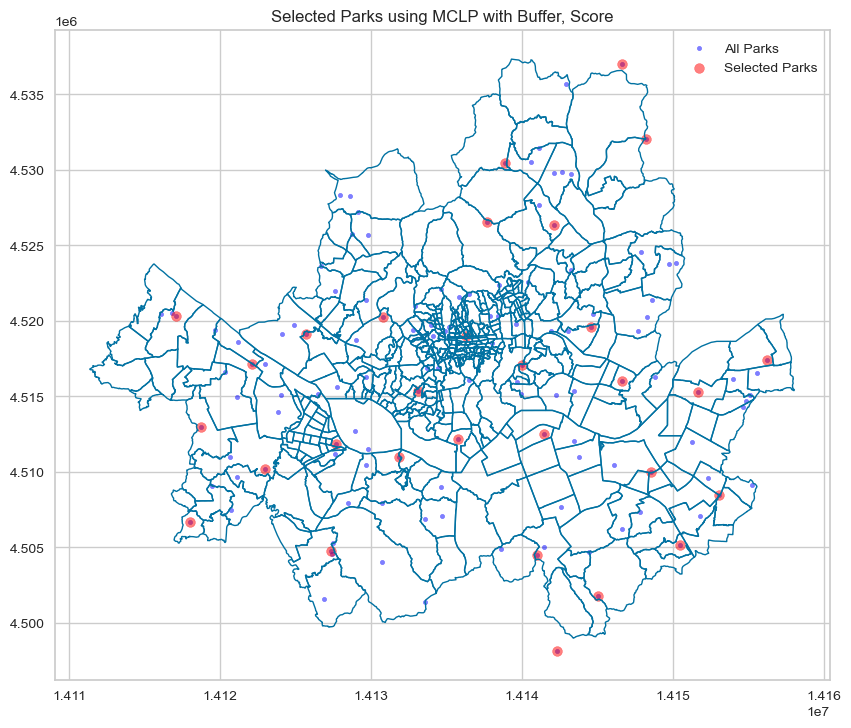

In [ ]:
## 최종수정본
centroids = new_seoul[['centroid']]
centroids = centroids.dropna()
centroids = centroids.reset_index(drop=True)
centroids_gdf = gpd.GeoDataFrame(centroids, crs='EPSG:4326', geometry='centroid')

def MCLP_with_buffer(centroids, facilities, coverage_buffers, num_facilities, score):
    covered = np.zeros((len(centroids), len(facilities)), dtype=bool)
    for i, facility in facilities.iterrows():
        buffer_geom = coverage_buffers[i]
        covered[:, i] = centroids.within(buffer_geom)

    selected = []
    selected_buffers = []
    for _ in range(num_facilities):
        best_covered = 0
        best_facility = None
        best_buffer = None
        for i, facility in facilities.iterrows():
            if i in selected:
                continue

            facility_score = score[i]
            buffer_geom = coverage_buffers[i]

            # Check if this buffer overlaps with any of the selected buffers
            if any(buffer_geom.intersects(selected_buffer) for selected_buffer in selected_buffers):
                continue

            new_covered = np.sum(facility_score * np.max(covered[:, selected + [i]], axis=1))
            if new_covered > best_covered:
                best_covered = new_covered
                best_facility = i
                best_buffer = buffer_geom

        if best_facility is not None:
            selected.append(best_facility)
            selected_buffers.append(best_buffer)

    return facilities.iloc[selected]
yy_gdf['buffer'] = yy_gdf.geometry.buffer(2000)
selected_points = MCLP_with_buffer(centroids_gdf, yy_gdf, yy_gdf['buffer'], 30, park_w_score)

fig, ax = plt.subplots(figsize=(10, 10))
new_seoul.boundary.plot(ax=ax, linewidth=1)
yy_gdf.plot(ax=ax, color='blue', alpha=0.5, markersize=10, label='All Parks')
selected_points.plot(ax=ax, color='red', alpha=0.5, markersize=50, label='Selected Parks')
plt.legend()
plt.title('Selected Parks using MCLP with Buffer, Score')
plt.show()


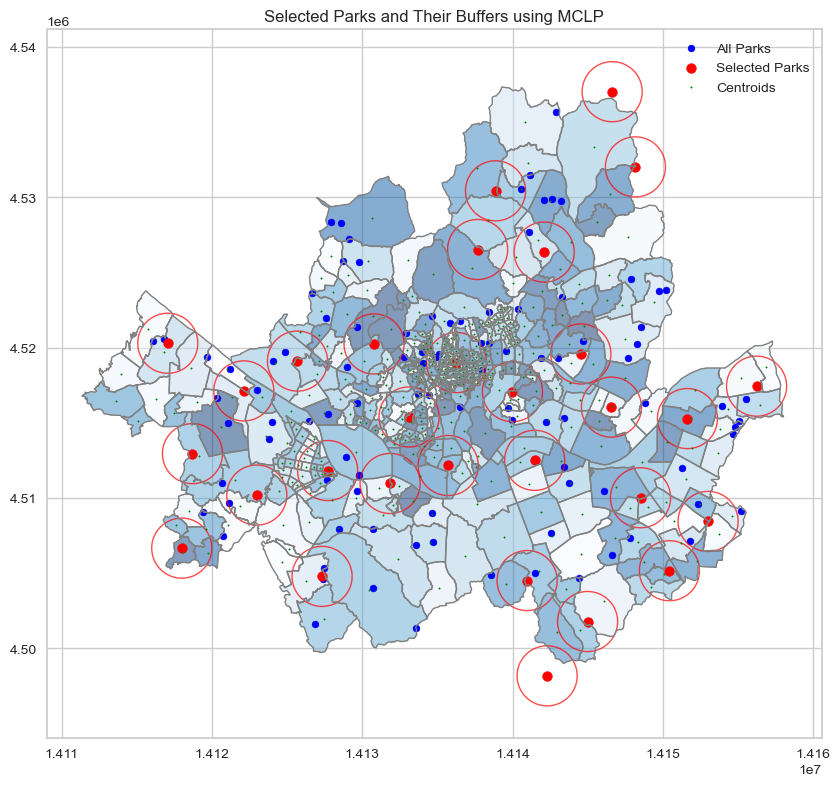

In [ ]:
# MCLP with buffer
# Plotting the selected points and their buffers
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Seoul regions
new_seoul.boundary.plot(ax=ax, linewidth=1, edgecolor='gray')
new_seoul.plot(column='EMD_KOR_NM', ax=ax, cmap='Blues', edgecolor='gray', alpha=0.5)

# Plot all park points
yy_gdf.plot(ax=ax, color='blue', markersize=25, label='All Parks')

# Plot buffers of selected parks
selected_points['buffer'].plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.7, linewidth=1, label='Selected Park Buffer')

# Plot selected park points
selected_points.plot(ax=ax, color='red', markersize=50, label='Selected Parks')

# Plot centroids
new_seoul['centroid'].plot(ax=ax, color='green', markersize=1, label='Centroids')

# Legend and title
plt.legend()
plt.title("Selected Parks and Their Buffers using MCLP")
plt.show()

In [ ]:
selected_points

,공원명,구,경도,위도,geometry,buffer,cluster
40,탑골근린공원,종로구,126.988285,37.571005,POINT (14136271.256 4518999.241),"POLYGON ((14138271.256 4518999.241, 14138261.6...",28
6,중마루근린공원,영등포구,126.911267,37.519832,POINT (14127697.596 4511814.493),"POLYGON ((14129697.596 4511814.493, 14129687.9...",8
8,매화근린공원,강서구,126.861150,37.557583,POINT (14122118.619 4517114.321),"POLYGON ((14124118.619 4517114.321, 14124108.9...",13
36,꿩고개근린공원,강서구,126.815708,37.580159,POINT (14117059.983 4520284.890),"POLYGON ((14119059.983 4520284.890, 14119050.3...",18
104,문화예술공원,서초구,127.030517,37.467654,POINT (14140972.468 4504493.742),"POLYGON ((14142972.468 4504493.742, 14142962.8...",10
113,인능산도시자연공원,서초구,127.066663,37.448211,POINT (14144996.244 4501767.116),"POLYGON ((14146996.244 4501767.116, 14146986.6...",21
110,청계산도시자연공원,서초구,127.042473,37.422435,POINT (14142303.359 4498153.452),"POLYGON ((14144303.359 4498153.452, 14144293.7...",21
23,효창근린공원,용산구,126.959930,37.545234,POINT (14133114.759 4515380.332),"POLYGON ((14135114.759 4515380.332, 14135105.1...",3
83,송파나루근린공원(석촌호수),송파구,127.098300,37.506933,POINT (14148518.059 4510004.215),"POLYGON ((14150518.059 4510004.215, 14150508.4...",22
50,장지근린공원,송파구,127.138700,37.495708,POINT (14153015.344 4508429.220),"POLYGON ((14155015.344 4508429.220, 14155005.7...",16


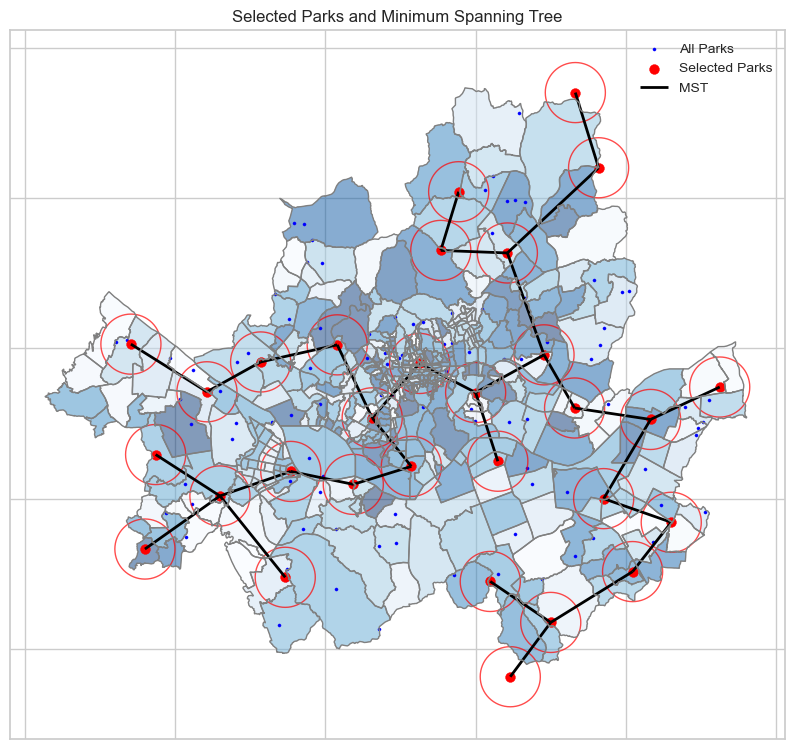

In [ ]:
# Create a graph
G = nx.Graph()

# Add nodes
for idx, row in selected_points.iterrows():
    G.add_node(idx, pos=(row.geometry.x, row.geometry.y))

# Add edges with distances as weights
for i, row1 in selected_points.iterrows():
    for j, row2 in selected_points.iterrows():
        if i != j:
            distance = row1.geometry.distance(row2.geometry)
            G.add_edge(i, j, weight=distance)

# Get positions for the nodes in the graph
pos = nx.get_node_attributes(G, 'pos')

# Find the Minimum Spanning Tree (MST) to ensure all nodes are connected with minimum distance
mst = nx.minimum_spanning_tree(G, weight='weight')

# Plotting the selected points, their buffers, and the MST
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Seoul regions
new_seoul.boundary.plot(ax=ax, linewidth=1, edgecolor='gray')
new_seoul.plot(column='EMD_KOR_NM', ax=ax, cmap='Blues', edgecolor='gray', alpha=0.5)

# Plot all park points
yy_gdf.plot(ax=ax, color='blue', markersize=5, label='All Parks')

# Plot buffers of selected parks
selected_points['buffer'].plot(ax=ax, facecolor='none', edgecolor='red', alpha=0.7, linewidth=1, label='Selected Park Buffer')

# Plot selected park points
selected_points.plot(ax=ax, color='red', markersize=50, label='Selected Parks')

# Plot centroids
# new_seoul['centroid'].plot(ax=ax, color='green', markersize=1, label='Centroids')

# Plot the Minimum Spanning Tree
mst_edges = list(mst.edges())
nx.draw_networkx_edges(G, pos, edgelist=mst_edges, ax=ax, edge_color='black', width=2, label='MST')

# Legend and title
plt.legend()
plt.title("Selected Parks and Minimum Spanning Tree")
plt.show()